In [16]:
from functools import partial
from dataclasses import replace

import colorcet as cc
import diffrax as dfx
import lineax.internal as lxi
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import scipy.spatial as scspatial
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.dataset import TimeSeriesDataset
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.models import (
    LatentLSTM as LatentLSTM,
    LatentRNN as LatentRNN,
    NeuralODE as NeuralODE,
)
from dynamics_discovery.preprocessing import add_noise, standardize, downsample
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

In [2]:
def seminorm(u: tuple[Array, Array]) -> float:
    return lxi.rms_norm(u[0])


class LocalSensitivity(eqx.Module):
    ode: NeuralODE
    stepsize_controller: dfx.AbstractStepSizeController = eqx.field(static=True)
    use_seminorm: bool = eqx.field(static=True)
    second_order: bool = eqx.field(static=True)

    def __init__(
        self, ode: NeuralODE, use_seminorm: bool = True, second_order: bool = False
    ):
        self.ode = ode
        self.second_order = second_order
        self.use_seminorm = use_seminorm
        stepsize_controller = self.ode.stepsize_controller
        if self.use_seminorm and isinstance(stepsize_controller, dfx.PIDController):
            self.stepsize_controller = replace(stepsize_controller, norm=seminorm)
        else:
            self.stepsize_controller = stepsize_controller

    @property
    def solver(self) -> dfx.AbstractSolver:
        return self.ode.solver

    @property
    def dt0(self) -> float | None:
        return self.ode.dt0

    def rhs(self, t, u, args):
        y, Dy = u
        z = y + Dy

        def rhs_y(y_):
            return self.ode.rhs(t, y_, args)

        def first_order(y_):
            return eqx.filter_jvp(rhs_y, (y_,), (z - y_,))

        if not self.second_order:
            dy, dDy = first_order(y)
        else:
            (dy, dDy_1), (_, dDy_2) = eqx.filter_jvp(first_order, (y,), (Dy,))
            dDy = 1.5 * dDy_1 + 0.5 * dDy_2
        return dy, dDy

    def solve(self, ts: Float[Array, " time"], u0, args=None, **kwargs):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(self.rhs),
            self.solver,
            ts[0],
            ts[-1],
            self.dt0,
            u0,
            args,
            saveat=dfx.SaveAt(ts=ts),
            stepsize_controller=self.stepsize_controller,
            **kwargs,
        )
        return sol.ys


In [28]:
dataset_loaded = TimeSeriesDataset.load("./data/lorenz63.hdf5")[30000:]
noise = 0.05
keep_every = 5

t_train = dataset_loaded.t[0]
t_train = t_train[::keep_every]
u_orig = downsample(dataset_loaded.u[0], keep_every)
u_orig = add_noise(u_orig, noise)
u_train = standardize(u_orig)
u_std = jnp.std(u_orig, axis=0)

lorenz = Lorenz63()

In [4]:
n_rollout = 2
kdtree = scspatial.KDTree(u_train[:-n_rollout])

num_neighbors = 25
_, idx_nn_ = kdtree.query(u_train[:-n_rollout], k=num_neighbors + 1)
idx_nn = idx_nn_[:, 1:]

In [5]:
model = LocalSensitivity(NeuralODE(3, 32, 3, key=0), second_order=True)

idx_test = 30
u0 = u_train[idx_test]
du0 = jnp.take(u_train, idx_nn[idx_test], axis=0) - u0

ts = t_train[idx_test : idx_test + n_rollout]

In [6]:
u0.shape

(3,)

In [7]:
y1 = eqx.filter_vmap(model.solve, in_axes=(None, (None, 0)), out_axes=(None, 0))(
    ts, (u0, du0)
)

In [8]:
y1[1].shape

(25, 2, 3)

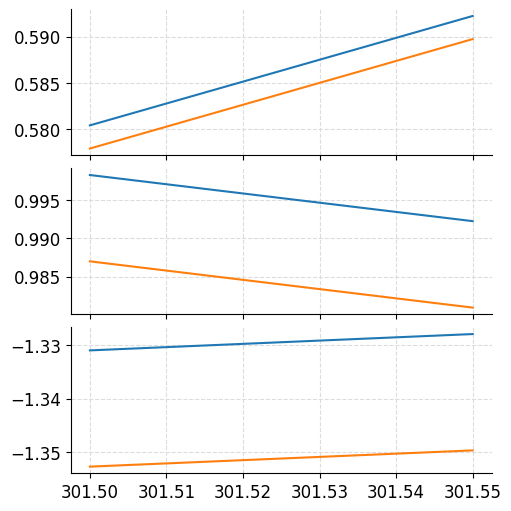

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(5, 5), sharex=True)
for i, ax in enumerate(axes):
    ax.plot(ts, y1[0][:, i])
    ax.plot(ts, y1[0][:, i] + y1[1][0, :, i])

In [6]:
@partial(eqx.filter_vmap, in_axes=(None, None, None, 0, None, None))
def jacobian_loss(model, t_train, u_train, idx, idx_nn, train_length):
    ts = jax.lax.dynamic_slice_in_dim(t_train, idx, train_length, axis=0)
    us = jax.lax.dynamic_slice_in_dim(u_train, idx, train_length, axis=0)
    dus = (
        jnp.stack(
            [jnp.take(u_train, idx_nn[idx + i], axis=0) for i in range(train_length)],
            axis=1,
        )
        - us
    )

    _, dus_pred = eqx.filter_vmap(
        model.solve, in_axes=(None, (None, 0)), out_axes=(None, 0)
    )(ts, (us[0], dus[:, 0]))
    return jnp.mean((dus_pred - dus) ** 2) / jnp.mean(dus**2)


@eqx.filter_value_and_grad
def jacobian_loss_grad(model, t_train, u_train, idx_nn, train_length):
    idx = jnp.arange(u_train.shape[0] - train_length)
    return jnp.mean(jacobian_loss(model, t_train, u_train, idx, idx_nn, train_length))

In [11]:
optimizer = optax.adabelief(learning_rate=5e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))


@eqx.filter_jit
def step_fn(model, t_train, u_train, idx_nn, opt_state):
    loss, grads = jacobian_loss_grad(model, t_train, u_train, idx_nn, n_rollout)
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [12]:
loss_history = []
max_epochs = 2500
for epoch in range(max_epochs):
    loss, model, opt_state = step_fn(model, t_train, u_train, idx_nn, opt_state)
    loss_history.append(loss.item())
    print(f"{epoch=}, {loss=}")
loss_history = jnp.asarray(loss_history)

2025-05-01 14:10:42.131887: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 22.61GiB (24277413992 bytes) by rematerialization; only reduced to 23.50GiB (25238956379 bytes), down from 23.91GiB (25669793523 bytes) originally


epoch=0, loss=Array(0.97859288, dtype=float64)
epoch=1, loss=Array(0.97779164, dtype=float64)
epoch=2, loss=Array(0.97692655, dtype=float64)
epoch=3, loss=Array(0.97590106, dtype=float64)
epoch=4, loss=Array(0.97460903, dtype=float64)
epoch=5, loss=Array(0.97293438, dtype=float64)
epoch=6, loss=Array(0.97074477, dtype=float64)
epoch=7, loss=Array(0.96788885, dtype=float64)
epoch=8, loss=Array(0.9641986, dtype=float64)
epoch=9, loss=Array(0.95949641, dtype=float64)
epoch=10, loss=Array(0.95360354, dtype=float64)
epoch=11, loss=Array(0.94634452, dtype=float64)
epoch=12, loss=Array(0.93754443, dtype=float64)
epoch=13, loss=Array(0.92702031, dtype=float64)
epoch=14, loss=Array(0.91457374, dtype=float64)
epoch=15, loss=Array(0.90000478, dtype=float64)
epoch=16, loss=Array(0.88315233, dtype=float64)


KeyboardInterrupt: 

Text(0, 0.5, 'Train error')

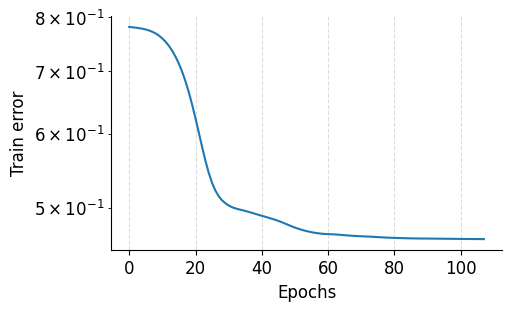

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_history)
ax.set_yscale("log", base=10)
ax.set_xlabel("Epochs")
ax.set_ylabel("Train error")

In [7]:
def step(ode, t0, t1, u0):
    sol = dfx.diffeqsolve(
        dfx.ODETerm(ode.rhs),
        dfx.Tsit5(),
        t0,
        t1,
        None,
        u0,
        stepsize_controller=dfx.PIDController(rtol=1e-7, atol=1e-7),
        args=None,
    )
    return sol.ys[0]


@partial(eqx.filter_vmap, in_axes=(None, 0, 0, None))
def jacobian_one_step(ode, t, u, dt):
    @eqx.filter_jacrev
    def _jac_step(t_u):
        t, u = t_u
        return step(ode, t, t + dt, u)

    return _jac_step((t, u))[1]


jac_unscaled = jacobian_one_step(lorenz, t_train, u_orig, t_train[1] - t_train[0])
jac_true = jnp.diag(1 / u_std) @ jac_unscaled @ jnp.diag(u_std)

In [8]:
@partial(eqx.filter_vmap, in_axes=(None, 0, 0, None))
def jacobian_one_step_model(model, t, u, dt):
    @eqx.filter_jacrev
    def _jac_step(t_u):
        t, u = t_u
        return model.step(t, t + dt, u)

    return _jac_step((t, u))[1]

In [38]:
jac_nn = jacobian_one_step_model(model.ode, t_train, u_train, t_train[1] - t_train[0])
err_nn = relative_error_norm(jac_nn, jac_true, axis=(-2, -1))

In [39]:
jac_nn[0]

Array([[ 0.24413719, -0.00732962,  0.00729466],
       [ 0.02598671,  0.21633047,  0.01848323],
       [-0.06075159, -0.0485365 ,  0.15944421]], dtype=float64)

In [40]:
jac_true[0]

Array([[ 0.75659363,  0.46154801,  0.05608911],
       [ 0.55929311,  1.08540477,  0.24408521],
       [-0.43995742, -0.3826239 ,  0.83303066]], dtype=float64)

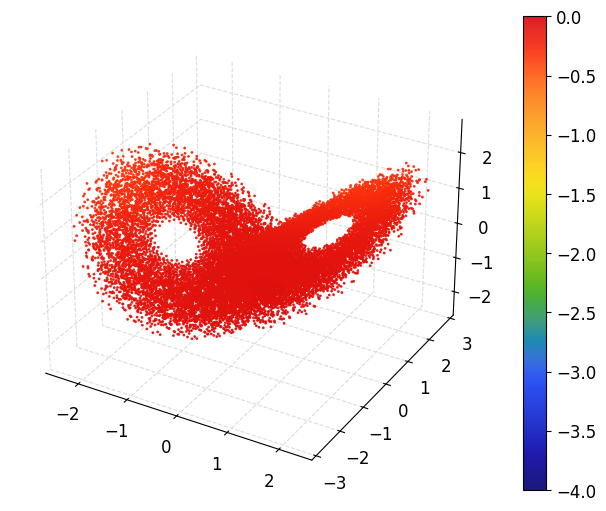

In [41]:
scatter_kwargs = {"s": 1, "cmap": cc.cm.rainbow4, "vmin": -4, "vmax": 0.0, "alpha": 0.9}
fig, axes = plt.subplots(
    1,
    1,
    figsize=(7, 5),
    subplot_kw={"projection": "3d"},
)

plot = axes.scatter(*u_train.T, c=jnp.log10(err_nn), **scatter_kwargs)
fig.colorbar(plot, ax=axes)

In [9]:
@partial(eqx.filter_vmap, in_axes=(None, None, None, 0, None, None, None))
def hybrid_loss(
    model, t_train, u_train, idx, idx_nn, train_length, jac_weight: float = 1.0
):
    ts = jax.lax.dynamic_slice_in_dim(t_train, idx, train_length, axis=0)
    us = jax.lax.dynamic_slice_in_dim(u_train, idx, train_length, axis=0)
    dus = (
        jnp.stack(
            [jnp.take(u_train, idx_nn[idx + i], axis=0) for i in range(train_length)],
            axis=1,
        )
        - us
    )

    @partial(eqx.filter_vmap, in_axes=(None, 0), out_axes=(None, 0))
    def _solve(u0, du0):
        return model.solve(
            ts,
            (u0, du0),
            max_steps=256,
            adjoint=dfx.RecursiveCheckpointAdjoint(checkpoints=64),
        )

    us_pred, dus_pred = _solve(us[0], dus[:, 0])
    return jnp.mean((us_pred - us) ** 2) / jnp.mean(us**2) + jac_weight * jnp.mean(
        (dus_pred - dus) ** 2
    ) / jnp.mean(dus**2)


@eqx.filter_value_and_grad
def hybrid_loss_grad(
    model, t_train, u_train, idx_nn, train_length, jac_weight: float = 1.0
):
    idx = jnp.arange(u_train.shape[0] - train_length)
    return jnp.mean(
        hybrid_loss(model, t_train, u_train, idx, idx_nn, train_length, jac_weight)
    )

In [10]:
model = LocalSensitivity(NeuralODE(3, 32, 3, key=0), second_order=True)

optimizer = optax.adabelief(learning_rate=5e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_inexact_array))


@eqx.filter_jit
def step_fn(model, t_train, u_train, idx_nn, opt_state):
    loss, grads = hybrid_loss_grad(
        model, t_train, u_train, idx_nn, train_length=3, jac_weight=0.01
    )
    updates, opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [11]:
loss_history = []
max_epochs = 2500
for epoch in range(max_epochs):
    loss, model, opt_state = step_fn(model, t_train, u_train, idx_nn, opt_state)
    loss_history.append(loss.item())
    print(f"{epoch=}, {loss=}")
loss_history = jnp.asarray(loss_history)

2025-05-01 14:12:04.098492: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3021] Can't reduce memory use below 22.61GiB (24277413992 bytes) by rematerialization; only reduced to 22.87GiB (24555056439 bytes), down from 23.27GiB (24985871903 bytes) originally


epoch=0, loss=Array(0.3206737, dtype=float64)
epoch=1, loss=Array(0.31845664, dtype=float64)
epoch=2, loss=Array(0.31608097, dtype=float64)
epoch=3, loss=Array(0.31339779, dtype=float64)
epoch=4, loss=Array(0.31023745, dtype=float64)
epoch=5, loss=Array(0.30639121, dtype=float64)
epoch=6, loss=Array(0.30161417, dtype=float64)
epoch=7, loss=Array(0.29563573, dtype=float64)
epoch=8, loss=Array(0.28817544, dtype=float64)
epoch=9, loss=Array(0.27896279, dtype=float64)
epoch=10, loss=Array(0.26776812, dtype=float64)
epoch=11, loss=Array(0.25444944, dtype=float64)
epoch=12, loss=Array(0.23902621, dtype=float64)
epoch=13, loss=Array(0.22181555, dtype=float64)
epoch=14, loss=Array(0.20366741, dtype=float64)
epoch=15, loss=Array(0.18630522, dtype=float64)
epoch=16, loss=Array(0.17257339, dtype=float64)
epoch=17, loss=Array(0.16536712, dtype=float64)
epoch=18, loss=Array(0.1636034, dtype=float64)
epoch=19, loss=Array(0.16201608, dtype=float64)
epoch=20, loss=Array(0.15754357, dtype=float64)
epoc

KeyboardInterrupt: 

Text(0, 0.5, 'Train error')

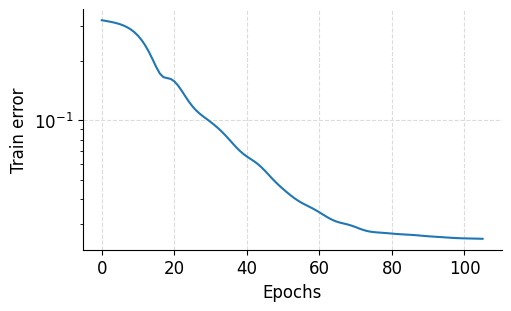

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(loss_history)
ax.set_yscale("log", base=10)
ax.set_xlabel("Epochs")
ax.set_ylabel("Train error")

In [19]:
@partial(eqx.filter_vmap, in_axes=(None, 0, 0))
def estimate_jacobian(us: Float[Array, "time dim"], idx, idx_nn):
    u0, u1 = us[idx], us[idx + 1]
    u_nn0 = jnp.take(us, idx_nn, axis=0)
    u_nn1 = jnp.take(us, idx_nn + 1, axis=0)

    du0 = u_nn0 - u0
    du1 = u_nn1 - u1
    return (jnp.linalg.pinv(du0) @ du1).T


jac_linregress = estimate_jacobian(u_train, jnp.arange(u_train.shape[0] - 2), idx_nn)
err_linregress = relative_error_norm(jac_linregress, jac_true[:-2], axis=(-2, -1))


Text(0.5, 0.98, 'Relative 1-step Jacobian error: downsample = 5, noise = 0.05')

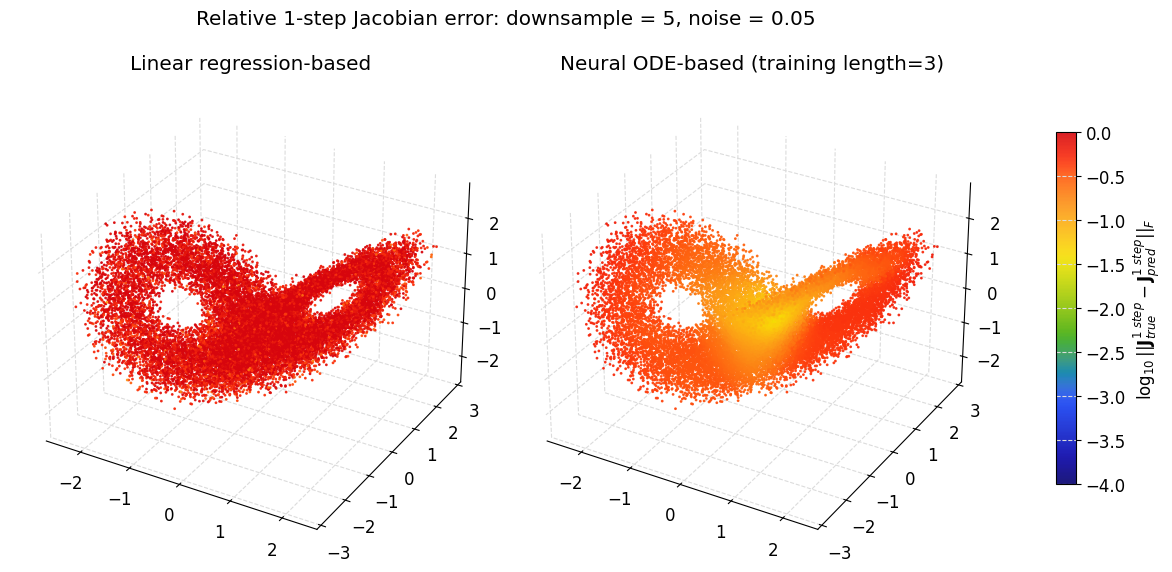

In [29]:
jac_nn = jacobian_one_step_model(model.ode, t_train, u_train, t_train[1] - t_train[0])
err_nn = relative_error_norm(jac_nn, jac_true, axis=(-2, -1))

scatter_kwargs = {"s": 1, "cmap": cc.cm.rainbow4, "vmin": -4, "vmax": 0.0, "alpha": 0.9}

fig = colored_scatterplot(
    (u_train[:-2].T, u_train.T),
    (jnp.log10(err_linregress), jnp.log10(err_nn)),
    figsize=(10, 6),
    **scatter_kwargs,
)
fig.axes[0].set_title("Linear regression-based")
fig.axes[1].set_title("Neural ODE-based (training length=3)")
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}^{1\ step}_{true}-\mathbf{J}^{1\ step}_{pred}||_F$"
)
fig.suptitle(
    f"Relative 1-step Jacobian error: downsample = {keep_every}, noise = {noise}"
)

In [30]:
from dynamics_discovery.preprocessing import split_into_chunks

n_rollout = 3
t_train_batch = split_into_chunks(t_train, n_rollout)
u_train_batch = split_into_chunks(u_train, n_rollout)
# u_train_batch = add_noise(u_train_batch, noise, key=0)

subsample_factor = u_train_batch.shape[0] // 100
print(t_train_batch.shape)
u_pred_train = eqx.filter_vmap(model.ode.solve)(
    t_train_batch[::subsample_factor], u_train_batch[::subsample_factor, 0]
)
u_pred_test = model.ode.solve(t_train, u_train[0], max_steps=None)


(6666, 3)


Text(0.5, 0.98, 'Neighborhood-aware training (train length = 3, seed = 0)')

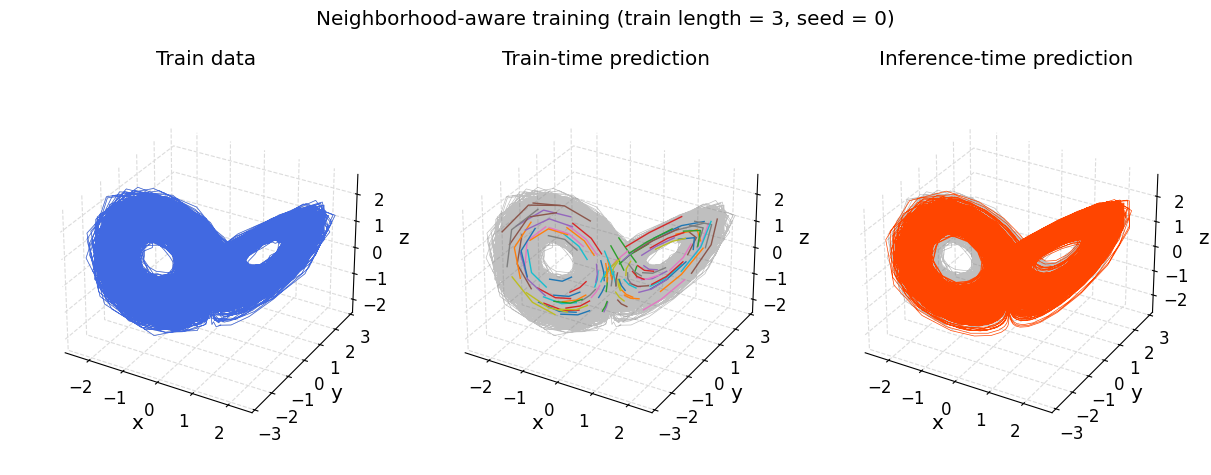

In [32]:
import numpy as np
from matplotlib_utils.axes_setters import set_labels


fig, axes = plt.subplots(
    1,
    3,
    figsize=(12, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].set_title("Train data")
axes[0].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
axes[0].plot(*u_train.T, color="royalblue", **plot_kwargs)

axes[1].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
for u_i in np.asarray(u_pred_train)[::]:
    axes[1].plot(*u_i.T, linewidth=1.0)
axes[1].set_title("Train-time prediction")
axes[2].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
axes[2].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[2].set_title("Inference-time prediction")

for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)
    ax.set_title
fig.suptitle(f"Neighborhood-aware training (train length = {n_rollout}, seed = 0)")
